lab_test_failure_v2.ipynb

Author: UFO Software, LLC
Created: Wednesday, July 13, 2021 12:25

License GPLv3+: GNU GPL version 3 or later https://gnu.org/licenses/gpl.html 
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.

Reads in the LabResults_0.csv and Batches_0.csv files from the December 2020 WA State Traceability Data and predicts if a cannabis sample will pass or fail lab testing.<br/>
This notebook is an update to the original lab_test_failure.ipynb notebook, it omits the exploratory work and has a defined goal of maximizing true possitives, minimizing false negatives and not optimizing false negatives.

In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
from pathlib import Path
import os

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_gpu_device_count

# change the file path to match where your data is stored
file_path = Path('../dec-2020')
pd.set_option('display.max_columns', None)

In [2]:
# random state seed for repeatability
seed = 42

# the goal of this notebook is predict if a sample will fail lab testing
## to avoid data leakage load only the data that is known before testing is completed

In [3]:
def get_lab_results_df():
    # reduce the size of the dataframe's memory footprint by specifying data types
    col_dtypes = {'global_id' : 'string',
                 'mme_id' : 'category',
                 'user_id' : 'string',
                 'external_id' : 'string',
                 'inventory_id' : 'string',
                 'status' : 'category',
                 'testing_status' : 'category',
                 'batch_id' : 'string',
                 'type' : 'category',
                }

    date_cols = ['created_at',
                 #'deleted_at',
                 'updated_at',
                 'tested_at',
                 #'received_at' deprecated
                ]

    # combine the column names to load only the columns you are using
    cols = list(col_dtypes.keys()) + date_cols

    lab_results_df = pd.read_csv(file_path / 'LabResults_0.csv', sep = '\t', encoding = 'utf-16', usecols = cols, dtype = col_dtypes, parse_dates = date_cols)
    
    lab_results_df.rename(columns={'mme_id':'lab_id'}, inplace=True)
 
    return lab_results_df

# read in batches dataframe to get the producer id

In [4]:
def get_batches_df():
    col_dtypes = {'global_id':'string',
                  'mme_id':'category',
                  #'strain_id':'category'
    }
    cols = list(col_dtypes.keys())
    batches_df = pd.read_csv(file_path / 'Batches_0.csv', sep = '\t', encoding = 'utf-16', usecols = cols, dtype = col_dtypes)
    batches_df.rename(columns={'global_id':'batch_id', 'mme_id':'producer_id'}, inplace=True)
    
    return batches_df

In [5]:
lab_results_df = get_lab_results_df()

# remove empty entries and only include tests that have been completed

In [6]:
lab_results_df.drop(lab_results_df[lab_results_df.status == 'not tested'].index, inplace=True)
lab_results_df['status'] = lab_results_df.status.cat.remove_unused_categories()
lab_results_df.reset_index(drop = True, inplace = True)

In [7]:
lab_results_df = lab_results_df[lab_results_df.testing_status != 'in_progress'].copy()

In [8]:
lab_results_df['testing_status'] = lab_results_df.status.cat.remove_unused_categories()
lab_results_df.dropna(subset = ['testing_status'], inplace = True)
lab_results_df.reset_index(drop = True, inplace = True)

In [9]:
lab_results_df.dropna(subset=['batch_id'], inplace = True)
lab_results_df.reset_index(drop = True, inplace = True)

In [10]:
#drop the rows where the type is null
lab_results_df.dropna(subset=['type'], inplace = True)
lab_results_df.reset_index(drop = True, inplace = True)

In [11]:
batches_df = get_batches_df()

In [12]:
batches_df.dropna(subset=['batch_id'], inplace = True)
batches_df.reset_index(drop = True, inplace = True)

# merge the lab results and batches dataframes using the batch id

In [13]:
lab_results_df = pd.merge(lab_results_df, batches_df, how = 'left', on = ['batch_id'])

# There is less than a 1% failure rate
The classifier will need to compensate for the class imballance

In [14]:
lab_results_df.status.value_counts(normalize=True)

passed    0.99245
failed    0.00755
Name: status, dtype: float64

# encode the fail / pass status to 0 / 1

In [15]:
le = preprocessing.LabelEncoder()
le.fit(lab_results_df['status'])
y = le.transform(lab_results_df['status'])

# split the data into training and testing sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(lab_results_df[['type', 'lab_id','producer_id']], y, test_size = 0.2, random_state = seed)

# Calculate class weights to compensate for the fail / pass class imaballance

In [17]:
classes = np.unique(y_train)
cw = class_weight.compute_class_weight('balanced', classes = classes, y = y_train)
weights = dict(zip(classes,cw))

# Define the columns that contain categorical data

In [18]:
cat_cols = [0,1,2]

# Use a CatBoost Classifier to predict the which samples will fail
The paramaters for the classifier were optimized using Optuna in a seperate notebook

In [19]:
model = CatBoostClassifier(class_weights=weights,
                           random_seed = seed,
                           verbose = False,
                           learning_rate = 0.73,
                           depth = 1,
                           l2_leaf_reg = 1,
                           iterations = 200,
                           bootstrap_type = 'MVS',
                           simple_ctr = 'Borders',
                           combinations_ctr = 'Borders',
                           model_size_reg = 0.69,
                           max_ctr_complexity = 14)
model.fit(X_train, y_train, cat_cols);
preds = model.predict(X_test)

# The classifier correctly predicts all but one of the failures
But is incorrectly labels over 88 thousand passing samples as failing

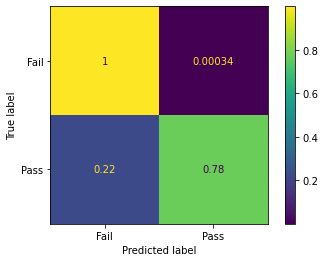

In [20]:
class_names = ['Fail', 'Pass']
disp = plot_confusion_matrix(model, X_test, y_test, display_labels = class_names, normalize = 'true')

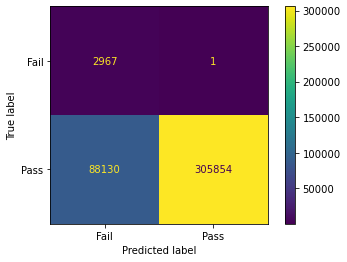

In [21]:
disp = plot_confusion_matrix(model, X_test, y_test, display_labels = class_names)

# The Lab ID is the most important feature followed by the Product Type

In [22]:
model.get_feature_importance()

array([19.7617073 , 80.01761886,  0.22067384])

# What is driving the results?

In [23]:
# Build a dataframe that combines the label and the prediction along with the features
X_test.reset_index(inplace=True)
predictions = pd.concat([X_test, pd.Series(y_test), pd.Series(preds)], axis = 1)
predictions.rename(columns = {0: 'label', 1:'prediction'}, inplace = True)

# Marijuana is predicted to fail 99% of the time
But Marijuana really only fails 12% of the time<br>
Marijuana makes up 12% of the training data

In [24]:
(len(predictions.loc[(predictions['type'] == 'marijuana') & (predictions['prediction'] == 0)]) / len(X_test.loc[X_test.type == "marijuana"])) * 100

99.54062589721504

In [25]:
(len(predictions.loc[(predictions['type'] == 'marijuana') & (predictions['prediction'] == 0)]) / len(predictions['prediction'] == 0)) * 100

12.227674882605454

In [39]:
(len(X_train.loc[(X_train['type'] == 'marijuana')]) / len(X_train)) * 100

12.33777153016708

# End Product is predicted to fail 1.5% of the time
End Product actually fails 1% of the time<br>
End Product makes up 68% of the training data

In [27]:
(len(predictions.loc[(predictions['type'] == 'end_product') & (predictions['prediction'] == 0)]) / len(X_test.loc[X_test.type == "end_product"])) * 100

1.5427241741932116

In [28]:
(len(predictions.loc[(predictions['type'] == 'end_product') & (predictions['prediction'] == 0)]) / len(predictions['prediction'] == 0)) * 100

1.0421914992240875

In [41]:
(len(X_train.loc[(X_train['type'] == 'end_product')]) / len(X_train)) * 100

67.56853950133738

# Harvest Materials is predicted to fail 58% of the time
But Harvest Materials really only fails 7% of the time<br>
Harvest Materials make up 13% of the training data

In [30]:
(len(predictions.loc[(predictions['type'] == 'harvest_materials') & (predictions['prediction'] == 0)]) / len(X_test.loc[X_test.type == "harvest_materials"])) * 100

58.20206841686555

In [31]:
(len(predictions.loc[(predictions['type'] == 'harvest_materials') & (predictions['prediction'] == 0)]) / len(predictions['prediction'] == 0)) * 100

7.37217598097503

In [42]:
(len(X_train.loc[(X_train['type'] == 'harvest_materials')]) / len(X_train)) * 100

12.62143320945178

# Intermediate Product is predicted to fail 31% of the time
But Intermediate Product really only fails 2% of the time<br>
Intermediate Product makes up 7% of the training data

In [33]:
(len(predictions.loc[(predictions['type'] == 'intermediate_product') & (predictions['prediction'] == 0)]) / len(X_test.loc[X_test.type == "intermediate_product"])) * 100

30.79225233707714

In [34]:
(len(predictions.loc[(predictions['type'] == 'intermediate_product') & (predictions['prediction'] == 0)]) / len(predictions['prediction'] == 0)) * 100

2.306828029585441

In [43]:
(len(X_train.loc[(X_train['type'] == 'intermediate_product')]) / len(X_train)) * 100

7.4697995411281095

predictions.type.value_counts()

# End Product has the best performance because it comprises the majority of the training data
Can the classifier be improved by using a training set that has ballances the number of samples for each product type?